# Prepare matplotlib

In [5]:
from itertools import product

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import wandb

rc_fonts = {
    "text.usetex": True,
    "text.latex.preamble": "\n".join(
        [r"\usepackage{libertine}", r"\usepackage[libertine]{newtxmath}", r"\usepackage{inconsolata}"]
    ),
}
mpl.rcParams.update(rc_fonts)

wandb.login()
api = wandb.Api()

# Load data

In [2]:
tiny_base = api.run("pico-lm/pico-relora/k718cxi3")
small_base = api.run("pico-lm/pico-relora/cjigjo80")
tiny_lora = api.run("pico-lm/pico-relora/ghbzaf4f")
small_lora = api.run("pico-lm/pico-relora/9nqespc7")

In [3]:
lora_keys = [
    f"cka_val/_forward_module.module.layers.{i}.{mod}.{ltype}.activations"
    for i in range(12)
    for mod in ("swiglu.w_2", "ov_circuit")
    for ltype in ("base", "full", "lora")
]
lora_keys.append("_step")

base_keys = [
    f"cka_val/_forward_module.module.layers.{i}.{mod}.activations"
    for i in range(12)
    for mod in ("swiglu.w_2", "ov_circuit")
]
base_keys.append("_step")


data = {
    "lora": {
        "tiny": pd.DataFrame(tiny_lora.scan_history(keys=lora_keys))
        .replace("NaN", np.nan, inplace=False)
        .infer_objects(copy=False),
        "small": pd.DataFrame(small_lora.scan_history(keys=lora_keys))
        .replace("NaN", np.nan, inplace=False)
        .infer_objects(copy=False),
    },
    "base": {
        "tiny": pd.DataFrame(tiny_base.scan_history(keys=base_keys))
        .replace("NaN", np.nan, inplace=False)
        .infer_objects(copy=False),
        "small": pd.DataFrame(small_base.scan_history(keys=base_keys))
        .replace("NaN", np.nan, inplace=False)
        .infer_objects(copy=False),
    },
}

/var/folders/2y/6ry1xqnj2r9_fpqf_pp017mw0000gn/T/ipykernel_38983/3038506182.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace("NaN", np.nan, inplace=False)
/var/folders/2y/6ry1xqnj2r9_fpqf_pp017mw0000gn/T/ipykernel_38983/3038506182.py:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace("NaN", np.nan, inplace=False)


In [4]:
def get_across_ranges(
    df: pd.DataFrame, metric_name: str, step_mod: int = 1, step_mod_offset: int = 0, *ranges
):
    if not ranges:
        ranges = (range(12),)
    combos = product(*ranges)
    df = df.drop_duplicates(subset=["_step"], inplace=False)
    mask = df["_step"] % step_mod == step_mod_offset
    df = df[mask]
    x = [df[metric_name.format(*combo)].replace("NaN", np.nan).to_numpy() for combo in combos]
    return np.column_stack(x)

In [77]:
def _get_cka_data():
    for mod in ("swiglu.w_2", "ov_circuit"):
        for t in data:
            for s in data[t]:
                metr_str = (
                    "cka_val/_forward_module.module.layers.{}"
                    + f".{mod}{'.base' if t == 'lora' else ''}.activations"
                )
                val = get_across_ranges(
                    data[t][s], metr_str, step_mod=2_000, step_mod_offset=0 if t == "base" else 100
                )
                for ckp_id, ckp in enumerate(val):
                    for lay_id, layer_val in enumerate(ckp):
                        yield (
                            r"OV Circuit" if "ov" in mod else r"Swiglu $W_2$",
                            rf"\texttt{{pico-{'decoder' if t == 'base' else 'relora'}}}",
                            s,
                            int(ckp_id * 2),
                            lay_id,
                            layer_val,
                        )


cka_data = pd.DataFrame(
    _get_cka_data(),
    columns=["Component", "Model", "Scale", "Step", "Layer", "CKA"],
)

cka_data["CKA"] = np.where(
    (cka_data["Scale"] == "small") & cka_data["Model"].str.contains("relora") & (cka_data["Step"] == 20),
    cka_data["CKA"].round(5),
    cka_data["CKA"],
)

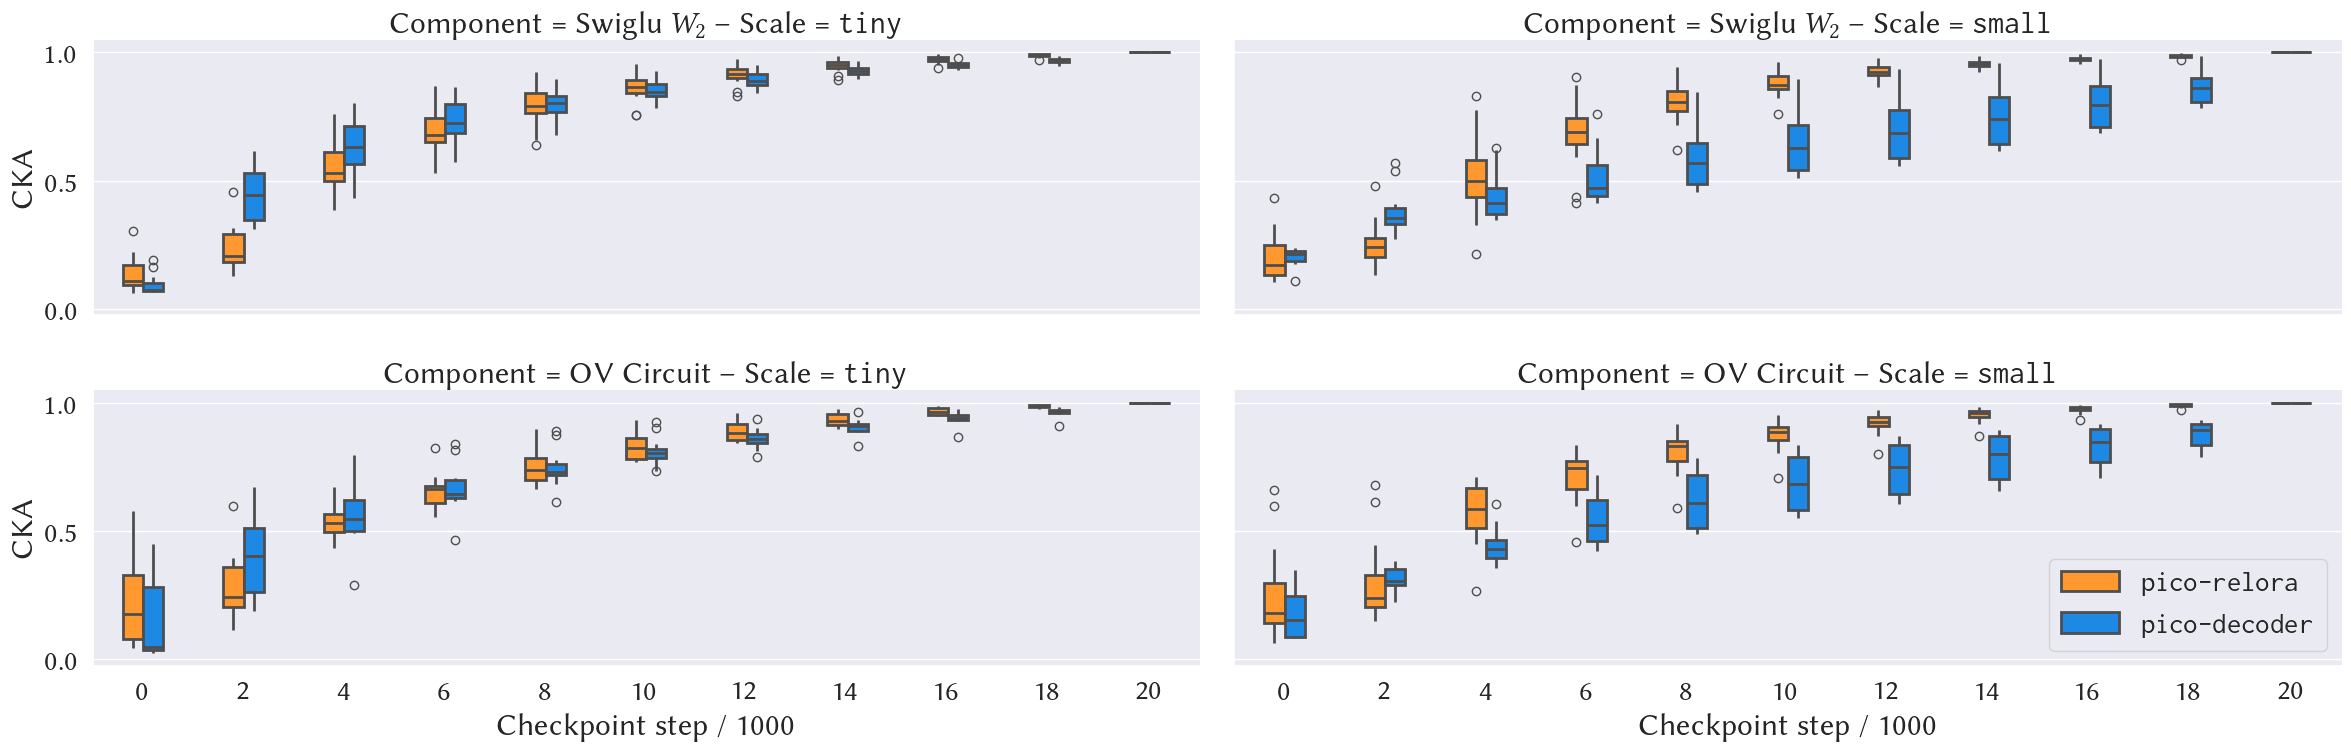

In [84]:
colors = ["#1E88E5", "#FF992F"]
models = sorted(cka_data["Model"].unique().tolist())
palette = dict(zip(models, colors))

dodge = 0.4
size = 8
font_scale = 1.9

sns.set_theme(font_scale=font_scale, rc={"axes.grid": "True", "axes.grid.which": "both"})

g = sns.FacetGrid(
    data=cka_data,
    col="Scale",
    row="Component",
    height=4,
    aspect=3,
    sharey=True,
    sharex=True,
    margin_titles=False,
)

g.set_titles(template=r"Component = {row_name} -- Scale = \texttt{{{col_name}}}")


g.map_dataframe(
    sns.boxplot,
    x="Step",
    y="CKA",
    hue="Model",
    palette=palette,
    saturation=1,
    linewidth=2,
    showcaps=False,
    width=0.4,
)

g.set_axis_labels("Checkpoint step / 1000", "CKA")

for idx, ax in enumerate(g.axes.flat):
    steps = cka_data["Step"].unique()

    if idx == 3:
        ax.legend(bbox_to_anchor=(1, 0), loc="lower right")

plt.savefig("../graphs/cka.pdf", bbox_inches="tight")
plt.show()

In [87]:
mask = (
    (cka_data["Scale"] == "small")
    & cka_data["Model"].str.contains("relora")
    & (cka_data["Step"] <= 2)
    & cka_data["Component"].str.contains("irc")
)
cka_data[mask]

,Component,Model,Scale,Step,Layer,CKA
660,OV Circuit,\texttt{pico-relora},small,0,0,0.658546
661,OV Circuit,\texttt{pico-relora},small,0,1,0.594922
662,OV Circuit,\texttt{pico-relora},small,0,2,0.428039
663,OV Circuit,\texttt{pico-relora},small,0,3,0.252709
664,OV Circuit,\texttt{pico-relora},small,0,4,0.249148
665,OV Circuit,\texttt{pico-relora},small,0,5,0.197997
666,OV Circuit,\texttt{pico-relora},small,0,6,0.158918
667,OV Circuit,\texttt{pico-relora},small,0,7,0.162722
668,OV Circuit,\texttt{pico-relora},small,0,8,0.153344
669,OV Circuit,\texttt{pico-relora},small,0,9,0.083660
